# WDSR

In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

from data import DIV2K
from model.wdsr import wdsr_b, wdsr_a
from train import WdsrTrainer

%matplotlib inline

In [2]:
# activate GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.experimental.list_logical_devices('GPU')

        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# Number of residual blocks
depth = 32

# Super-resolution factor
scale = 4

# Downgrade operator
downgrade = 'bicubic'

# Model type
model_type = 'b'

# Model
wdsr_model = wdsr_b

In [4]:
# Location of model weights (needed for demo)
weights_dir = f'weights/wdsr-{model_type}-{depth}-x{scale}'
weights_file = os.path.join(weights_dir, 'weights.h5')

os.makedirs(weights_dir, exist_ok=True)

## Datasets

You don't need to download the DIV2K dataset as the required parts are automatically downloaded by the `DIV2K` class. By default, DIV2K images are stored in folder `.div2k` in the project's root directory.

In [5]:
div2k_train = DIV2K(scale=scale, subset='train', downgrade=downgrade)
div2k_valid = DIV2K(scale=scale, subset='valid', downgrade=downgrade)

In [6]:
train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=1, random_transform=False, repeat_count=1)

## Training

### Pre-trained models

If you want to skip training and directly run the demo below, download [weights-wdsr-b-32-x4.tar.gz](https://martin-krasser.de/sisr/weights-wdsr-b-32-x4.tar.gz) and extract the archive in the project's root directory. This will create a `weights/wdsr-b-32-x4` directory containing the weights of the pre-trained model.

In [7]:
trainer = WdsrTrainer(model=wdsr_model(scale=scale, num_res_blocks=depth), 
                      checkpoint_dir=f'.ckpt/wdsr-{model_type}-{depth}-x{scale}')

In [8]:
# Train WDSR B model for 300,000 steps and evaluate model
# every 1000 steps on the first 10 images of the DIV2K
# validation set. Save a checkpoint only if evaluation
# PSNR has improved.
trainer.train(train_ds,
              valid_ds.take(10),
              steps=100000, 
              evaluate_every=1000, 
              save_best_only=True)

1000/100000: loss = 11.720, PSNR = 27.631451 (181.67s)
2000/100000: loss = 7.640, PSNR = 28.092770 (156.47s)
3000/100000: loss = 7.339, PSNR = 28.251453 (150.47s)
4000/100000: loss = 7.113, PSNR = 28.400578 (149.08s)
5000/100000: loss = 7.081, PSNR = 28.535196 (146.65s)
6000/100000: loss = 6.958, PSNR = 28.602270 (146.06s)
7000/100000: loss = 6.878, PSNR = 28.710312 (147.19s)
8000/100000: loss = 6.859, PSNR = 28.741186 (146.40s)
9000/100000: loss = 6.820, PSNR = 28.868521 (146.62s)
10000/100000: loss = 6.818, PSNR = 28.777210 (146.20s)
11000/100000: loss = 6.770, PSNR = 28.858707 (146.48s)
12000/100000: loss = 6.758, PSNR = 28.885105 (146.32s)
13000/100000: loss = 6.703, PSNR = 28.910553 (146.74s)
14000/100000: loss = 6.723, PSNR = 28.976828 (146.43s)
15000/100000: loss = 6.700, PSNR = 28.996029 (146.20s)
16000/100000: loss = 6.684, PSNR = 28.999426 (146.16s)
17000/100000: loss = 6.649, PSNR = 29.033466 (146.10s)
18000/100000: loss = 6.620, PSNR = 29.045727 (146.25s)
19000/100000: loss

In [9]:
# Restore from checkpoint with highest PSNR
trainer.restore()

Model restored from checkpoint at step 99000.


In [10]:
# Evaluate model on full validation set
psnr = trainer.evaluate(valid_ds)
print(f'PSNR = {psnr.numpy():3f}')

PSNR = 28.583281


In [11]:
# Save weights to separate location (needed for demo)
trainer.model.save_weights(weights_file)

## Demo

In [12]:
model = wdsr_model(scale=scale, num_res_blocks=depth)
model.load_weights(weights_file)

In [13]:
from model import resolve_single
from utils import load_image, plot_sample

def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    sr = resolve_single(model, lr)
    plot_sample(lr, sr)

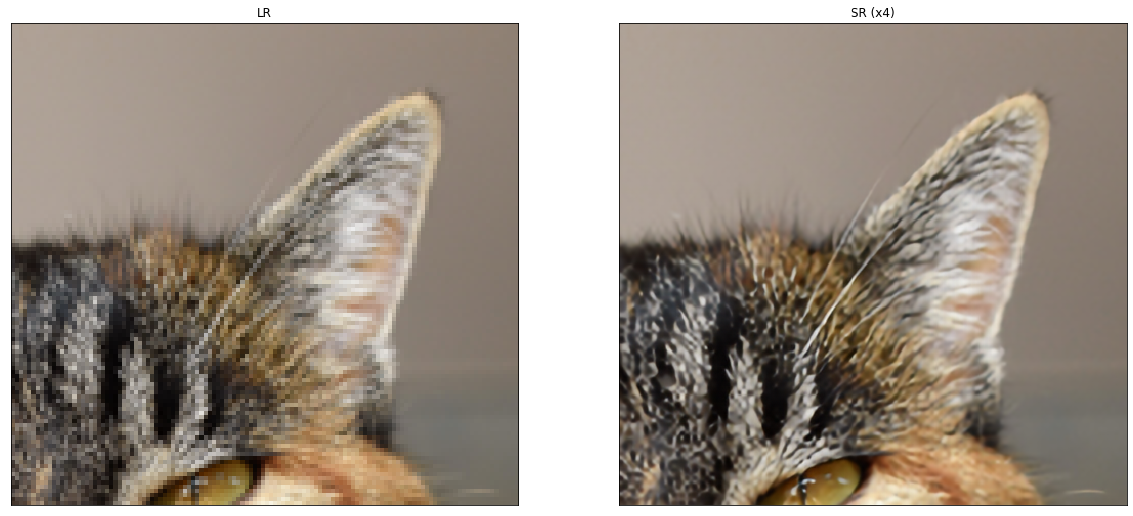

In [14]:
resolve_and_plot('demo/0869x4-crop.png')

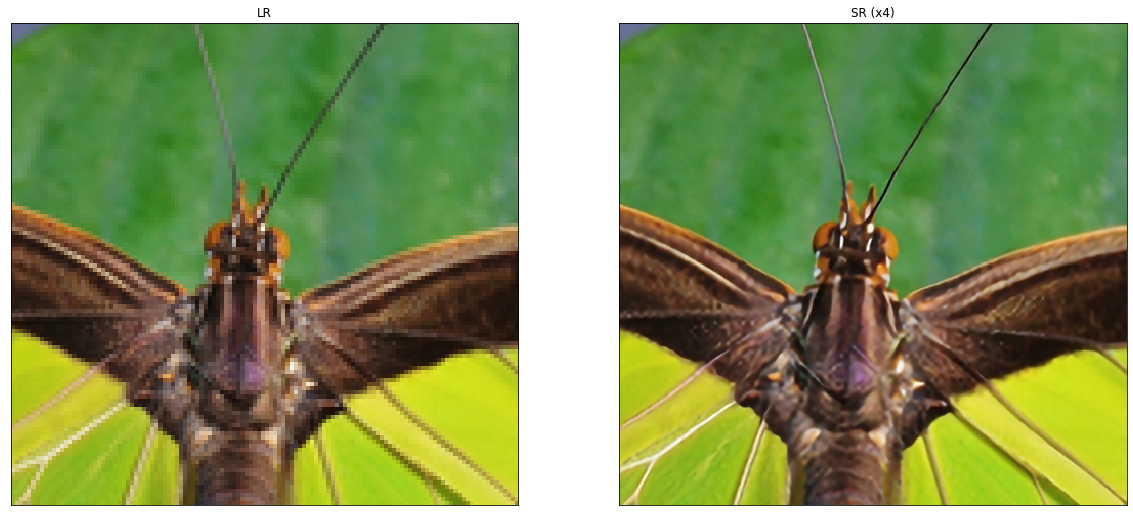

In [15]:
resolve_and_plot('demo/0829x4-crop.png')

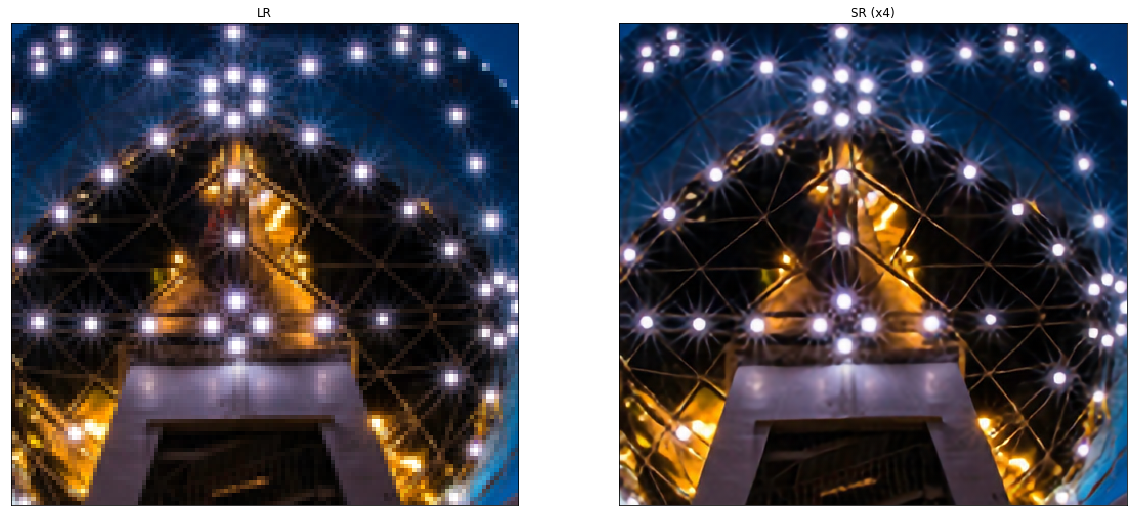

In [16]:
resolve_and_plot('demo/0851x4-crop.png')

In [17]:
weights_dir_a = f'weights/wdsr-a-{depth}-x{scale}'
weights_file_a = os.path.join(weights_dir_a, 'weights.h5')

model_a = wdsr_a(scale=scale, num_res_blocks=depth)
model_a.load_weights(weights_file_a)

weights_dir_b = f'weights/wdsr-b-{depth}-x{scale}'
weights_file_b = os.path.join(weights_dir_b, 'weights.h5')

model_b = wdsr_b(scale=scale, num_res_blocks=depth)
model_b.load_weights(weights_file_b)

def resolve_and_plot(model, lr_image_path):
    lr = load_image(lr_image_path)
    sr = resolve_single(model, lr)
    plot_sample(lr, sr)

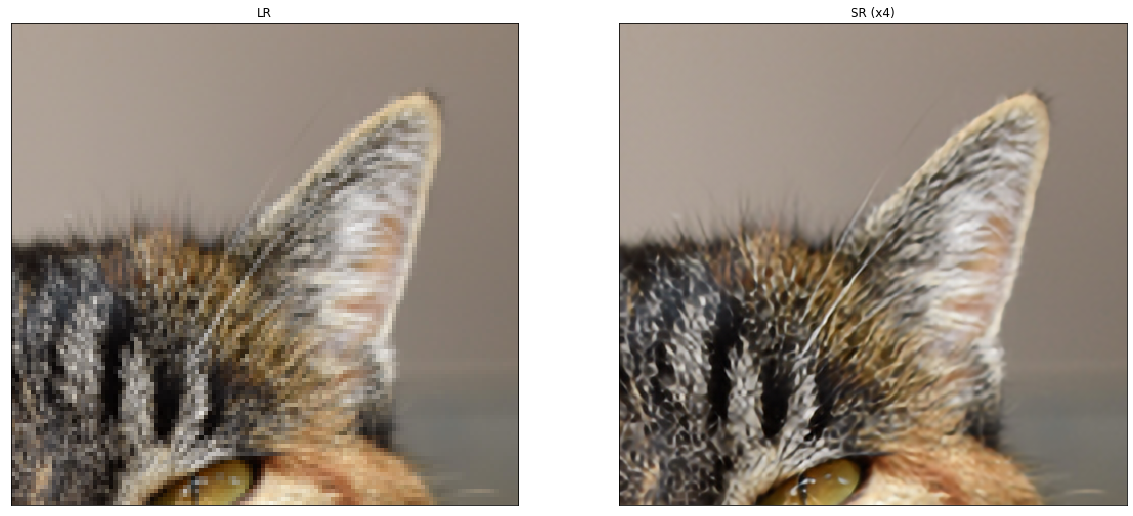

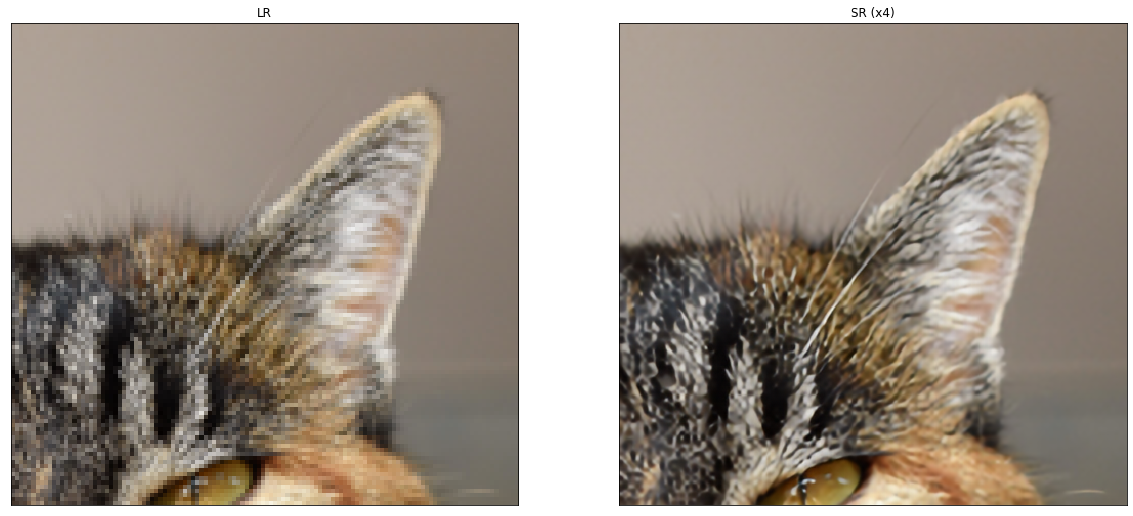

In [18]:
resolve_and_plot(model_a, 'demo/0869x4-crop.png')
resolve_and_plot(model_b, 'demo/0869x4-crop.png')

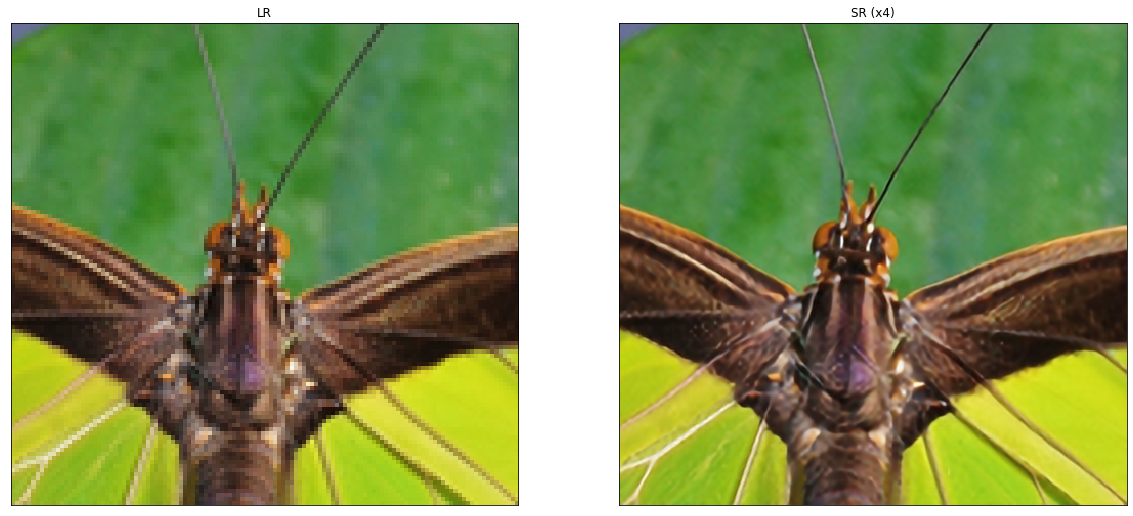

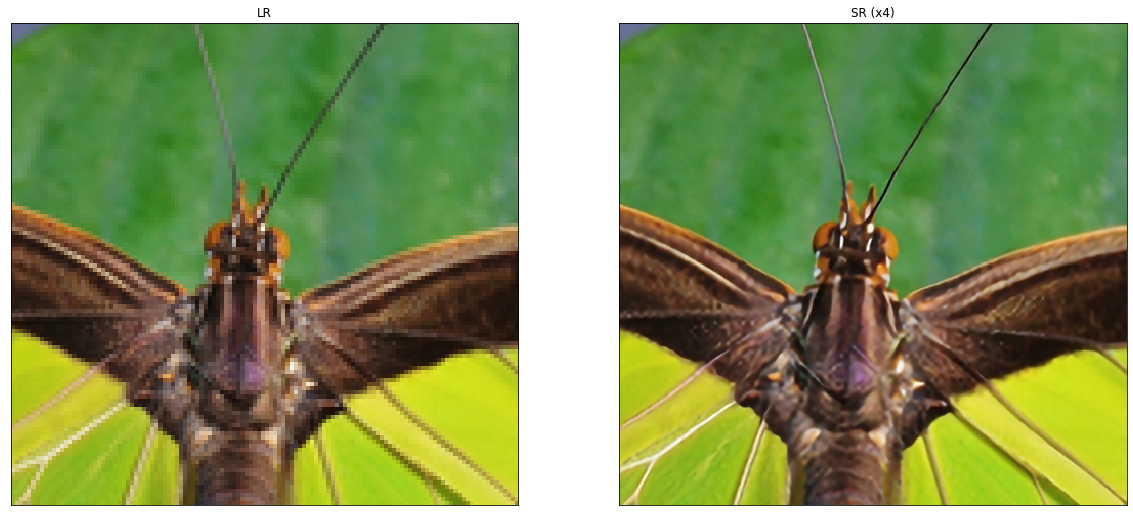

In [19]:
resolve_and_plot(model_a, 'demo/0829x4-crop.png')
resolve_and_plot(model_b, 'demo/0829x4-crop.png')